Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Szymon Budziak"
COLLABORATORS = "None"

---

# Lab 2: Inference in Graphical Models

### Machine Learning 2 (2024)

* The deadline is Friday, October 4th, 8:59.
* Assignment should be submitted through Canvas! Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid\_lab#", for example, the attached file should be "12345\_lab2.ipynb". 

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

In [2]:
import matplotlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import IPython
from typing import Union
from functools import reduce

# Check whether the environment is correct
assert int(sys.version[0]) == 3 and int(sys.version[2]) == 8
assert matplotlib.__version__ == "3.5.2"
assert np.__version__ == "1.22.3"
assert scipy.__version__ == "1.9.0"
assert (
    IPython.version_info[0] >= 3
), "Your version of IPython is too old, please update it."

In [3]:
# Since we're working with graphs, we'll install networkx
import networkx as nx

## Introduction
In this assignment, we will implement the sum-product and max-sum algorithms for factor graphs over discrete variables. The relevant theory is covered in chapter 8 of Bishop's PRML book, in particular section 8.4. Read this chapter carefuly before continuing!

We will implement sum-product and max-sum and apply it to a poly-tree structured medical diagnosis example.

For this assignment you should use numpy ndarrays (constructed with np.array, np.zeros, np.ones, etc.). We need n-dimensional arrays in order to store conditional distributions with more than one conditioning variable. If you want to perform matrix multiplication on arrays, use the np.dot function; all infix operators including *, +, -, work element-wise on arrays.

## Nodes 
In the following cell we will define classes for the variable nodes and factor nodes in the graph. It is important to understand how the messages are structured in the code. 

Variable nodes receive a message of size ```num_states``` from each of their neighbours. Therefore, the message is a numpy array of size ```num_neighbours x num_states ```. It is initalised as an array of ones. Factor nodes receive a message from each of their neighbours, of size ```num_states```. Since the number of states for each neighbour can differ, we cannot use a rectangular array to store these messages. Therefore, the message is a list of numpy arrays. The length of this list is ```num neighbours```. It is initialised with ```None```. 

As you can see, every neighbour is implicitly indexed. In order to allow neighbours to communicate, every node has an ```index``` function, which yields the index of the neighbour in the message of the root.

In [4]:
class Variable:
    """ Variable node in a factor graph"""
    def __init__(self, name, num_states):
        self.name = name
        self.num_states = num_states
        self.neighbours = []
    
    def reset(self):
        """ Initialise for message passing"""
        self.message = np.ones((len(self.neighbours), self.num_states))      
        self.received = []
        self.observed = None
        
    def index(self, factor):
        """ Get index of factor in message array"""
        return self.neighbours.index(factor)
    
    def set_observed(self, i):
        """ Set state i to be observed"""
        eps = 10/len(self.neighbours)
        self.message[:] = 10**-eps  # For numerical stability in logs
        self.message[:, i] = 1.
        self.observed = i
            
    def send_sp_message(self):
        """ Send message for sum-product"""
        raise NotImplementedError
    
    def send_ms_message(self):
        """ Send message for max-sum"""
        raise NotImplementedError
        
    def __str__(self):
        return self.name
    
class Factor:
    """Factor node in a factor graph"""
    def __init__(self, name, f, neighbours):
        self.name = name
        self.f = f        
        self.neighbours = neighbours
        for nb in self.neighbours:
            nb.neighbours.append(self)
    
    def reset(self):
        """ Initialise for message passing"""
        self.message = [None for i in range(len(self.neighbours))]
        self.received = []
     
    def index(self, variable):
        """ Get index of variable in message list"""
        return self.neighbours.index(variable)
        
    def send_sp_message(self):
        """ Send message for sum-product"""
        raise NotImplementedError
    
    def send_ms_message(self):
        """ Send message for max-sum"""
        raise NotImplementedError
        
    def __str__(self):
        return self.name

## Graph
All the inference will be run by the factor graph itself, which we define below. We have already implemented the inference engine for you, so there is no need to worry about that. You can use the helper methods to debug your code, if need be. Printing the graph will yield the marginals obtained after inference and using the ```show``` method will display the graph for you.

Every node in the graph keeps track of who it has received messages from. As soon as it has received messages from all of its neighbours, the node is done passing messages. The factor graphs calls upon every node to send messages until all nodes are satisfied. Then it computes the marginal for every node in the graph. 

In [5]:
class FactorGraph:
    """Factor graph for Sum-Product and Max-Sum"""
    def __init__(self, variables, factors):
        self.variables = variables
        self.factors = factors
        
    def reset(self):
        """Initialise for message passing"""
        for node in self.variables + self.factors:
            node.reset()
            
    def get(self, name):
        for v in self.variables + self.factors:
            if v.name == name:
                return v
        raise Exception("Node could not be found")

    def sum_product(self):
        """Run the sum-product algorithm"""
        while not self.converged():
            for node in self.variables + self.factors:
                node.send_sp_message()
                
        # Gather all messages
        for v in self.variables:
            v.message = np.prod(v.message, axis=0)
            
        # Compute normalisation constant using a single message
        Z = self.variables[0].message.sum()
        for v in self.variables:
            v.message /= Z
            
    def max_sum(self):
        """Run the max-product algorithm"""
        while not self.converged():
            for node in self.variables + self.factors:
                node.send_ms_message()
                
        # Gather all messages
        for v in self.variables:
            v.message = np.sum(v.message, axis=0)  
            
    
    def most_likely(self):
        """ Compute most likely state after running max-sum"""
        out = {}
        for v in self.variables:
            out[str(v)] = np.argmax(v.message)
        return out
    
        
    def converged(self):
        """Check for convergence"""
        for node in self.variables + self.factors:
            if len(node.received) != len(node.neighbours):
                return False
        return True
    
    def __str__(self):
        """ Display marginals of variable nodes"""
        return "\n".join(['{:<20} {:>30}'.format(str(v), str(v.message)) for v in self.variables])
        
    def draw(self):
        """Display graph"""
        G = nx.Graph()
        
        for node in self.variables:
            G.add_node(node)
            
            for nb in node.neighbours:
                G.add_edge(node, nb)
        
        plt.figure(figsize=(12, 8))
        nodePos = nx.layout.spring_layout(G)
        nx.draw_networkx_nodes(G,nodePos, self.variables)
        nx.draw_networkx_nodes(G,nodePos, self.factors, node_shape="s", node_color="g")
        nx.draw_networkx_edges(G,nodePos)
        nx.draw_networkx_labels(G, nodePos)

## 1.1 Initialize a simple graph (5 points)
We start with a set of three Bernoulli distributed variables X, Y, Z. Calculate the marginals $p(Y=1)$ and $p(Y=0)$ using only the sum and product rule where,

$$
p(X=1) = 0.05 \\\\
p(Z=1) = 0.2 \\\\
$$
$$
p(Y = 1 | X = 1, Z = 1) = 0.99 \\\\
p(Y = 1 | X = 1, Z = 0) = 0.9 \\\\
p(Y = 1 | X = 0, Z = 1) = 0.7 \\\\
p(Y = 1 | X = 0, Z = 0) = 0.0001 \\\\
$$

While implementing the message passing algorithms you should be able to use the results of this question as a guidance. Use the naming conventions implied by the test cell. Note that the order of the neighbours in the factor node and the array of the factor itself must match! Use the order [Y, X, Z] for the conditional factor.

# Answer

Given that $p(X=1) = 0.05$ we can obtain $p(X=0)$.

$p(X=0) = 1 - p(X=1) = 0.95$.

Similarly, $p(Z=0) = 1 - p(Z=1) = 0.8$.

Given both marginal probabilities fir $X$ and $Z$, we can now calculate the probability of $Y=1$ and then $Y=0$.

$$
p(Y=1) = \sum_X \sum_Z p(Y=1,X,Z)  = \sum_X \sum_Z p(Y=1|X,Z)p(X)p(Z) =\\
       = p(Y=1|X=1,Z=1)*p(X=1)*p(Z=1) + p(Y=1|X=1,Z=0)*p(X=1)*p(Z=0) +\\
       + p(Y=1|X=0,Z=1)*p(X=0)*p(Z=1) + p(Y=1|X=0,Z=0)*p(X=0)*p(Z=0) =\\
       = 0.99 * 0.05 * 0.2 + 0.9 * 0.05 * 0.8 + 0.7 * 0.95 * 0.2 + 0.0001 * 0.95 * 0.8 =\\
       = 0.178976
$$

Now we can obtain $p(Y=0)$.

$p(Y=0) = 1 - p(Y=1) = 0.821024$.

---

We can observe, that for $Y cond$ we also have to calculate $p(Y=0|X,Z)$, which is equal to $1 - p(Y=1|X,Z)$.

$p(Y=0|X=0, Z=0) = 1 - p(Y=1|X=0, Z=0) = 1 - 0.0001 = 0.9999$\
$p(Y=1|X=0, Z=1) = 1 - p(Y=1|X=0, Z=1) = 1 - 0.7 = 0.3$\
$p(Y=0|X=1, Z=0) = 1 - p(Y=1|X=1, Z=0) = 1 - 0.9 = 0.1$\
$p(Y=0|X=1, Z=1) = 1 - p(Y=1|X=1, Z=1) = 1 - 0.99 = 0.01$

In [6]:
def create_simple_graph():
    """
    Creates the simple graph from 1.1
    Returns: FactorGraph object
    """
    X = Variable(name="X", num_states=2)
    X_prior = Factor(
        name="p(X)",
        # p(X=0) and p(X=1)
        f=np.array([0.95, 0.05]),
        neighbours=[X],
    )

    # YOUR CODE HERE
    Z = Variable(name="Z", num_states=2)
    z_prior = Factor(
        name="p(Z)",
        # p(Z=0) and p(Z=1)
        f=np.array([0.8, 0.2]),
        neighbours=[Z],
    )

    Y = Variable(name="Y", num_states=2)
    Y_cond = Factor(
        name="p(Y|X,Z)",
        f=np.array(
            [
                # p(Y=0|X,Z) = 1 - p(Y=1|X,Z)
                [
                    [0.9999, 0.3],  # p(Y=0|X=0, Z=0), p(Y=0|X=0, Z=1)
                    [0.1, 0.01],  # p(Y=0|X=1, Z=0), p(Y=0|X=1, Z=1)
                ],
                # p(Y=1|X,Z)
                [
                    [0.0001, 0.7],  # p(Y=1|X=0, Z=0), p(Y=1|X=0, Z=1)
                    [0.9, 0.99],  # p(Y=1|X=1, Z=0), p(Y=1|X=1, Z=1)
                ],
            ]
        ),
        neighbours=[Y, X, Z],
    )

    return FactorGraph([X, Y, Z], [X_prior, Y_cond, z_prior])

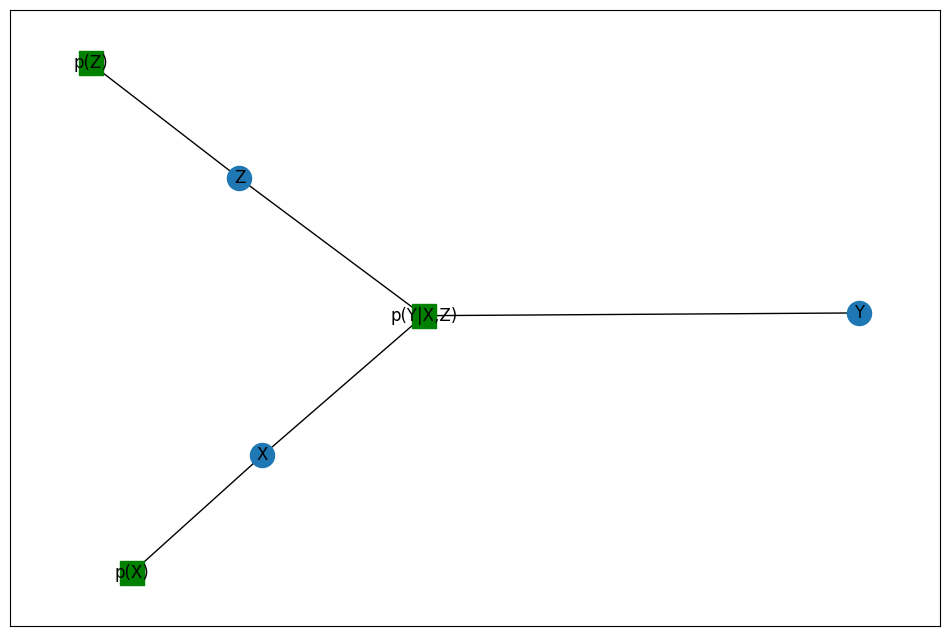

In [7]:
graph = create_simple_graph()
graph.draw()

X = graph.get("X")
Y = graph.get("Y")
Z = graph.get("Z")
Y_cond = graph.get("p(Y|X,Z)")
X_prior = graph.get("p(X)")
Z_prior = graph.get("p(Z)")

assert set(graph.variables) == set([X, Y, Z])
assert set(graph.factors) == set([Y_cond, X_prior, Z_prior])
assert Y_cond.neighbours == [Y, X, Z], "Please use the right variable order"
assert Y_cond.f.shape == (2, 2, 2), "Please check the shape of your factor array"

## 1.2 Helper functions (10 points)
Before we can get started with actual message passing, we will need to write some utility functions that we will use later on. First, we need a function that can compute the marginal of a discrete distribution over multiple variables. This happens in eqn (8.66) in Bishop:

$$
\sum_{x_1} ... \sum_{x_M} f_s(x, x_1, ..., x_M) \prod_{m \in ne(s) \setminus x} \mu_{x_m \rightarrow f_s} (x_m)
$$

Complete the function ```marginal```, which takes in a multidimensional array and computes the marginal of a specific dimension. 

In [8]:
def marginal(x: np.ndarray, dim: int) -> np.ndarray:
    """
    Get the marginal along dim

    Args:
        x (np.ndarray): Array to compute the marginal of
        dim (int): Dimension to compute the marginal along

    Returns:
        np.ndarray: Marginal of x along dim
    """
    # YOUR CODE HERE
    # Sum over all dimensions except the one we want to keep (dim)
    return np.sum(x, axis=tuple(i for i in range(x.ndim) if i != dim))

In [9]:
x = np.random.random((3, 13, 32, 4))

for i, shape in enumerate(x.shape):
    assert marginal(x, i).shape == (shape,)

Next, we need a function that computes which neighbours of a node are ready to receive a message. Complete the function ```get_recipients```, which returns a list of recipients. Make sure to check whether a message has already been sent using the neighbours ```received``` list! 

In [10]:
def get_recipients(node: Union[Variable, Factor]) -> list:
    """
    Get the neighbors that can receive a message from the node

    Args:
        node (Union[Variable, Factor]): Node to get recipients for

    Returns:
        list: List of nodes that can receive a message
    """
    # YOUR CODE HERE
    recipients = []

    for neighbor in node.neighbours:
        # Get all neighbors except the one we're sending to
        required_neighbors = set(node.neighbours).difference({neighbor})
        
        # Get all messages received by the node
        received_messages = set(node.received).difference({neighbor})
        
        # If all required messages are received and the node hasn't received a message from the neighbor add it to the recipients
        if (
            required_neighbors.issubset(received_messages)
            and node not in neighbor.received
        ):
            recipients.append(neighbor)

    return recipients

In [11]:
graph.reset()
assert get_recipients(X) == []
assert get_recipients(Y) == [Y_cond]
assert get_recipients(Z) == []
assert get_recipients(X_prior) == [X]
assert get_recipients(Z_prior) == [Z]
assert get_recipients(Y_cond) == []

Below are three more helper functions, which will be used in the computation of messages for the sum-product and max-sum algorithms. Study them carefully. 

In [12]:
def exclude_list(l, i):
    """Exclude the ith element from a list"""
    return l[:i] + l[i + 1 :]


def exclude_arr(x, i):
    """Exclude the ith row from an array"""
    dims = list(range(len(x)))
    dims.pop(i)
    return x[dims]


def outer_prod(l):
    """Computes the outer product of a list of vectors"""
    return reduce(np.multiply.outer, l)


def outer_sum(l):
    """Computes the outer sum of a list of vectors"""
    return reduce(np.add.outer, l)

## 2 The Sum-Product Algorithm (40 points)   

### 2.1 Factor Messages (10 points)
Now we really can get started on passing messages. First we write a function ```sp_factor_to_variable```. This function does a lot of things, so you may want to write helper functions—that's up to you. The function should implement eqn (8.66), which we restate here:

$$
\sum_{x_1} ... \sum_{x_M} f_s(x, x_1, ..., x_M) \prod_{m \in ne(s) \setminus x} \mu_{x_m \rightarrow f_s} (x_m)
$$

In short, it should obtain the recipients of the factor and for each of them
1. Get the relevant indices of the factor and the variable
2. Compute the outer product excluding the receiver
3. Multiply by the factor
4. Compute the marginal
5. Send the message to the variable
6. Update the variable's received list

We have already done some of these steps for you using the previously defined helper functions. Make sure to take into account leaf nodes and nodes set to observed states. 

In [13]:
def sp_factor_to_variable(self):
    """Send sum-product message from factor to node"""
    assert isinstance(self, Factor)

    recipients = get_recipients(self)
    print(f"[FACTOR] Sending message from {self.name} to {[str(r) for r in recipients]}")

    for variable in recipients:
        # YOUR CODE HERE
        assert isinstance(variable, Variable)

        # Get the index of the variable and the factor
        variable_index = self.index(variable)
        factor_index = variable.index(self)

        # Get messages from all neighbors except the recipient
        incoming_messages = exclude_list(self.message, variable_index)

        # Compute the product of all messages except the recipient
        if not incoming_messages:
            # If there are no incoming messages, the product is 1
            product_of_message = np.ones(self.f.shape)
        else:
            # Compute the outer product of the incoming messages
            product_of_message = outer_prod(incoming_messages)
            # Expand the dimension of the product for the recipient variable
            product_of_message = np.expand_dims(
                product_of_message, axis=variable_index
            )
            # Repeat the product along the recipient variable dimension
            product_of_message = np.repeat(
                product_of_message, variable.num_states, axis=variable_index
            )
            # f_shape = (d_1, d_2, ..., d_n)
            # pom_shape = (d_1, d_2, ..., d_vi-1, d_vi+1, ..., d_n)

        # Multiply the product of messages with the factor
        multiplied_message = self.f * product_of_message

        # Compute the marginal of the multiplied message
        marginal_message = marginal(multiplied_message, variable_index)

        # If the variable is observed, set the marginal to 0 except for the observed state
        if variable.observed is not None:
            tmp = np.zeros(variable.num_states)
            tmp[variable.observed] = marginal_message[variable.observed]
            marginal_message = tmp

        # Send the message to the variable from the factor
        variable.message[factor_index] = marginal_message

        # Add the factor to the received list of the variable
        variable.received.append(self)


Factor.send_sp_message = sp_factor_to_variable

[FACTOR] Sending message from Fx to ['X']


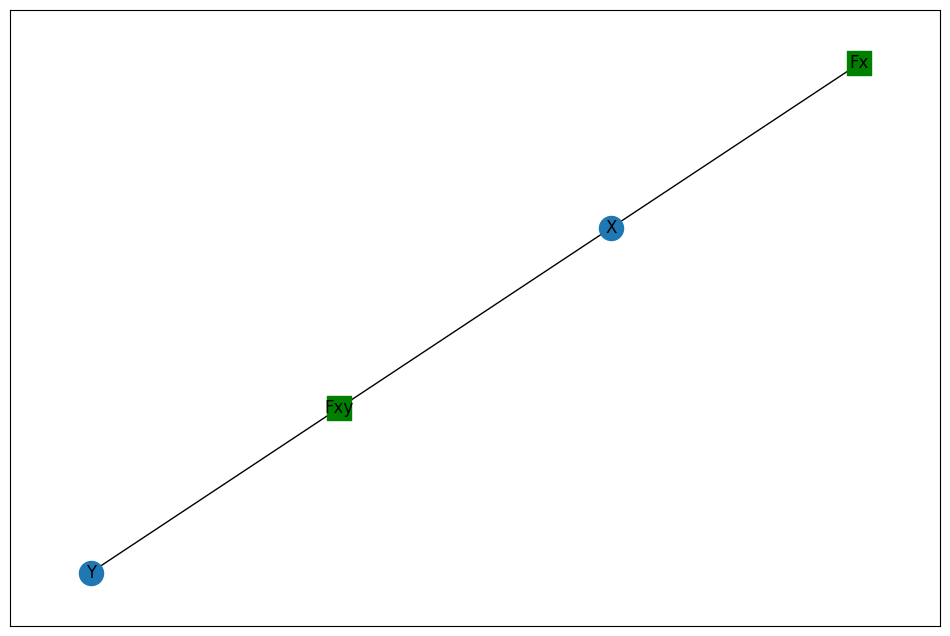

In [14]:
np.random.seed(42)

X = Variable("X", 3)
Y = Variable("Y", 2)
Fx = Factor("Fx", np.random.random(3), [X])
Fxy = Factor("Fxy", np.random.random((3, 2)), [X, Y])
graph = FactorGraph([X, Y], [Fxy, Fx])
graph.reset()
graph.draw()
Fx.send_sp_message()

assert X.message.shape == (2, 3)

### 2.2 Variable Messages (10 points)

Next, of course, is to implement the message from variables to factors according to Bishop eqn (8.69). We restate it here:

$$
\mu_{x_m \rightarrow f_s}(x_m) = \prod_{l \in ne(x_m) \setminus f_s} \mu_{f_l \rightarrow x_m}(x_m)
$$

In order to compute this, the function ```sp_variable_to_factor``` needs to get all recipients of the variable and for each of these factors, compute the product of all factors excluding the recipient.

In [15]:
def sp_variable_to_factor(self):
    """Send sum-product message from variable to factor"""
    assert isinstance(self, Variable)

    recipients = get_recipients(self)
    print(f"[VARIABLE] Sending message from {self.name} to {[str(r) for r in recipients]}")

    for factor in recipients:
        # YOUR CODE HERE
        assert isinstance(factor, Factor)
        
        # Get the index of the variable and the factor
        factor_index = self.index(factor)
        variable_index = factor.index(self)
        
        # Get all incoming messages except the recipient
        incoming_messages = exclude_arr(self.message, factor_index)

        # Compute the product of all incoming messages
        product_message = np.prod(incoming_messages, axis=0)
        
        if self.observed is not None:
            tmp = np.zeros(self.num_states)
            tmp[self.observed] = product_message[self.observed]
            product_message = tmp

        # Send the message to the factor from the variable
        factor.message[variable_index] = product_message

        # Add the variable to the received list of the factor
        factor.received.append(self)
    
Variable.send_sp_message = sp_variable_to_factor

In [16]:
np.random.seed(42)

X = Variable("X", 3)
Y = Variable("Y", 2)
Fx = Factor("Fx", np.random.random(3), [X])
Fxy = Factor("Fxy", np.random.random((3, 2)), [X, Y])
graph = FactorGraph([X, Y], [Fxy, Fx])
graph.reset()

Fx.send_sp_message()
X.send_sp_message()

assert Fxy.message[0].shape == (3,)

[FACTOR] Sending message from Fx to ['X']
[VARIABLE] Sending message from X to ['Fxy']


### 2.3 Sanity Check 

Let's run the algorithm on the graph for which you computed p(Y). Does the answer match your computations?

[VARIABLE] Sending message from X to []
[VARIABLE] Sending message from Y to ['p(Y|X,Z)']
[VARIABLE] Sending message from Z to []
[FACTOR] Sending message from p(X) to ['X']
[FACTOR] Sending message from p(Y|X,Z) to []
[FACTOR] Sending message from p(Z) to ['Z']
[VARIABLE] Sending message from X to ['p(Y|X,Z)']
[VARIABLE] Sending message from Y to []
[VARIABLE] Sending message from Z to ['p(Y|X,Z)']
[FACTOR] Sending message from p(X) to []
[FACTOR] Sending message from p(Y|X,Z) to ['Y', 'X', 'Z']
[FACTOR] Sending message from p(Z) to []
[VARIABLE] Sending message from X to ['p(X)']
[VARIABLE] Sending message from Y to []
[VARIABLE] Sending message from Z to ['p(Z)']
[FACTOR] Sending message from p(X) to []
[FACTOR] Sending message from p(Y|X,Z) to []
[FACTOR] Sending message from p(Z) to []


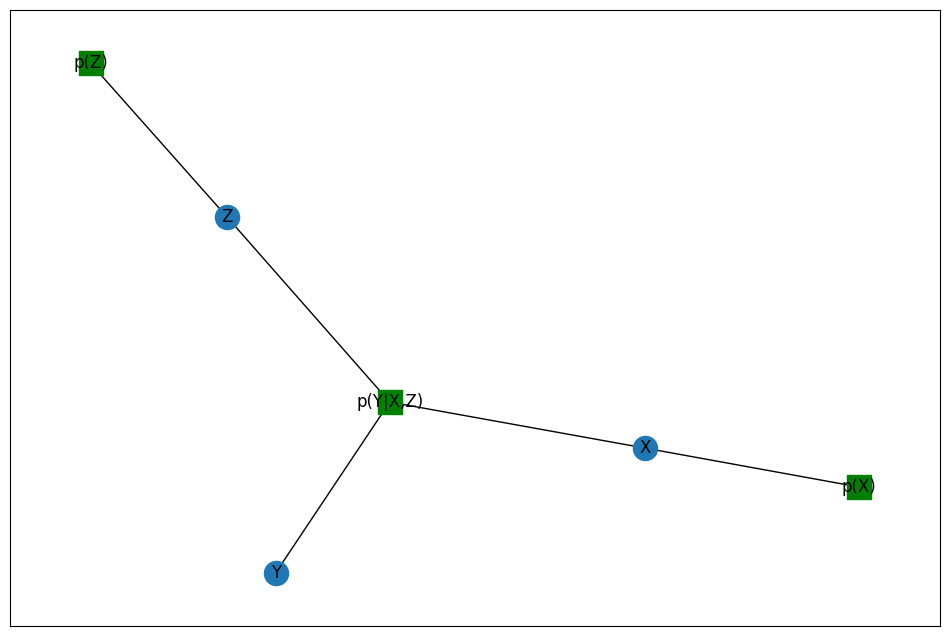

In [17]:
# YOUR CODE HERE
graph = create_simple_graph()
graph.reset()
graph.draw()
graph.sum_product()

In [18]:
print(graph)

X                                       [0.95 0.05]
Y                               [0.821024 0.178976]
Z                                         [0.8 0.2]


In [19]:
X = graph.get("X")
Y = graph.get("Y")
Z = graph.get("Z")
assert np.allclose(X.message, [0.95, 0.05])
assert np.allclose(Y.message, [0.821024, 0.178976])
assert np.allclose(Z.message, [0.8, 0.2])

### 2.4 Medical graph (20 points)

We now have all ingredients we need to run the sum-product algorithm. We will use a medical graph to test your algorithm. The graph is defined by the following Bayesian network:

$$
p(\verb+Influenza+) = 0.05 \\\\
p(\verb+Smokes+) = 0.2 \\\\
$$
$$
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.3 \\\\
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.001 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.9 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 0) = 0.05 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.9 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.7 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.8 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.07 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.6 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001 \\\\
$$

#### Calculations
$$
p(\verb+Influenza+ = 0) = 1 - 0.05 = 0.95 \\\
p(\verb+Smokes+ = 0) = 1 - 0.2 = 0.8 \\\\
$$

$$
p(\verb+SoreThroat+ = 0 | \verb+Influenza+ = 1) = 1 - 0.3 = 0.7 \\\\
p(\verb+SoreThroat+ = 0 | \verb+Influenza+ = 0) = 1 - 0.001 = 0.999 \\\\
$$

$$
p(\verb+Fever+ = 0| \verb+Influenza+ = 1) = 1 - 0.9 = 0.1 \\\\
p(\verb+Fever+ = 0| \verb+Influenza+ = 0) = 1 - 0.05 = 0.95 \\\\
$$

$$
p(\verb+Bronchitis+ = 0 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 1 - 0.99 = 0.01 \\\\
p(\verb+Bronchitis+ = 0 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 1 - 0.9 = 0.1 \\\\
p(\verb+Bronchitis+ = 0 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 1 - 0.7 = 0.3 \\\\
p(\verb+Bronchitis+ = 0 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 1 - 0.0001 = 0.9999 \\\\
$$

$$
p(\verb+Coughing+ = 0| \verb+Bronchitis+ = 1) = 1 - 0.8 = 0.2 \\\\
p(\verb+Coughing+ = 0| \verb+Bronchitis+ = 0) = 1 - 0.07 = 0.93 \\\\
$$

$$
p(\verb+Wheezing+ = 0| \verb+Bronchitis+ = 1) = 1 - 0.6 = 0.4 \\\\
p(\verb+Wheezing+ = 0| \verb+Bronchitis+ = 0) = 1 - 0.001 = 0.999 \\\\
$$

In [20]:
def create_medical_graph():
    """
    Create medical graph from 2.4
    returns: FactorGraph
    """
    I = Variable(name='Influenza', num_states=2)
    S = Variable(name='Smokes', num_states=2)
    ST = Variable(name='SoreThroat', num_states=2)
    F = Variable(name='Fever', num_states=2)
    B = Variable(name='Bronchitis', num_states=2)
    C = Variable(name='Coughing', num_states=2)
    W = Variable(name='Wheezing', num_states=2)

    # YOUR CODE HERE
    # Prior factor of Influenza
    I_prior = Factor(
        name="p(I)",
        f=np.array([0.95, 0.05]),  # p(I=0) and p(I=1)
        neighbours=[I],
    )

    # Prior factor of Smokes
    S_prior = Factor(
        name="p(S)",
        f=np.array([0.8, 0.2]),  # p(S=0) and p(S=1)
        neighbours=[S],
    )

    # Conditional factor of SoreThroat given Influenza
    ST_cond = Factor(
        name="p(ST|I)",
        f=np.array(
            [
                # p(ST=0|I) and p(ST=1|I)
                [0.999, 0.7],  # p(ST=0|I=0) and p(ST=0|I=1)
                [0.001, 0.3],  # p(ST=1|I=0) and p(ST=1|I=1)
            ]
        ),
        neighbours=[ST, I],
    )

    # Conditional factor of Fever given Influenza
    F_cond = Factor(
        name="p(F|I)",
        f=np.array(
            [
                # p(F=0|I) and p(F=1|I)
                [0.95, 0.1],  # p(F=0|I=0) and p(F=0|I=1)
                [0.05, 0.9],  # p(F=1|I=0) and p(F=1|I=1)
            ]
        ),
        neighbours=[F, I],
    )

    # Conditional factor of Bronchitis given Influenza and Smokes
    B_cond = Factor(
        name="p(B|I,S)",
        f=np.array(
            [
                # p(B=0|I,S)
                [
                    [0.9999, 0.3],  # p(B=0|I=0,S=0) and p(B=0|I=0,S=1)
                    [0.1, 0.01],
                ],  # p(B=0|I=1,S=0) and p(B=0|I=1,S=1)
                # p(B=1|I,S)
                [
                    [0.0001, 0.7],  # p(B=1|I=0,S=0) and p(B=1|I=0,S=1)
                    [0.9, 0.99],
                ],  # p(B=1|I=1,S=0) and p(B=1|I=1,S=1)
            ]
        ),
        neighbours=[B, I, S],
    )

    C_cond = Factor(
        name="p(C|B)",
        f=np.array(
            [
                # p(C=0|B) and p(C=1|B)
                [0.93, 0.2],  # p(C=0|B=0) and p(C=0|B=1)
                [0.07, 0.8],  # p(C=1|B=0) and p(C=1|B=1)
            ]
        ),
        neighbours=[C, B],
    )

    W_cond = Factor(
        name="p(W|B)",
        f=np.array(
            [
                # p(W=0|B) and p(W=1|B)
                [0.999, 0.4],  # p(W=0|B=0) and p(W=0|B=1)
                [0.001, 0.6],  # p(W=1|B=0) and p(W=1|B=1)
            ]
        ),
        neighbours=[W, B],
    )

    return FactorGraph(
        [I, S, ST, F, B, C, W],
        [I_prior, S_prior, ST_cond, F_cond, B_cond, C_cond, W_cond],
    )

[VARIABLE] Sending message from Influenza to []
[VARIABLE] Sending message from Smokes to []
[VARIABLE] Sending message from SoreThroat to ['p(ST|I)']
[VARIABLE] Sending message from Fever to ['p(F|I)']
[VARIABLE] Sending message from Bronchitis to []
[VARIABLE] Sending message from Coughing to ['p(C|B)']
[VARIABLE] Sending message from Wheezing to ['p(W|B)']
[FACTOR] Sending message from p(I) to ['Influenza']
[FACTOR] Sending message from p(S) to ['Smokes']
[FACTOR] Sending message from p(ST|I) to ['Influenza']
[FACTOR] Sending message from p(F|I) to ['Influenza']
[FACTOR] Sending message from p(B|I,S) to []
[FACTOR] Sending message from p(C|B) to ['Bronchitis']
[FACTOR] Sending message from p(W|B) to ['Bronchitis']
[VARIABLE] Sending message from Influenza to ['p(B|I,S)']
[VARIABLE] Sending message from Smokes to ['p(B|I,S)']
[VARIABLE] Sending message from SoreThroat to []
[VARIABLE] Sending message from Fever to []
[VARIABLE] Sending message from Bronchitis to ['p(B|I,S)']
[VARIABL

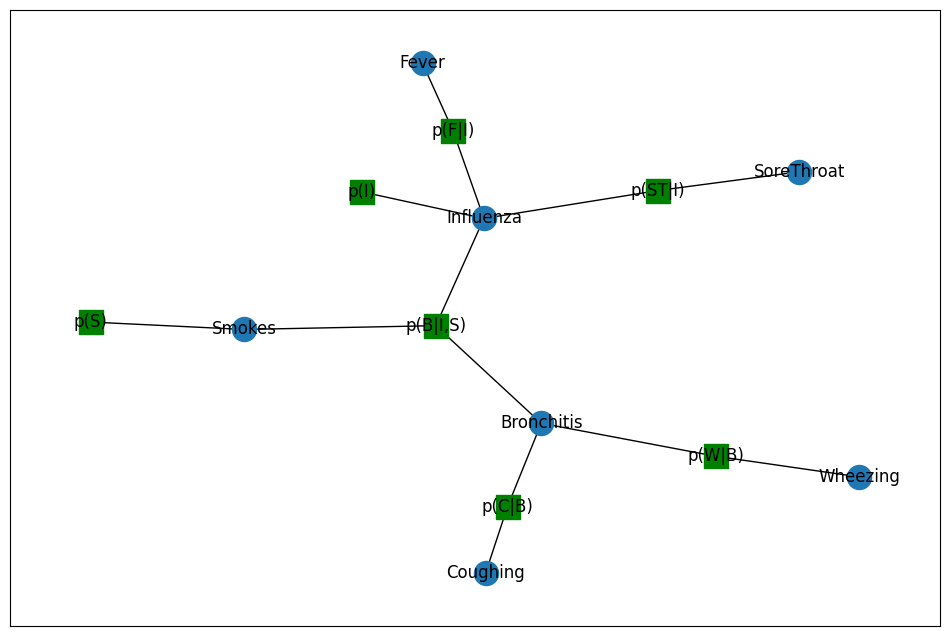

In [21]:
graph = create_medical_graph()
graph.reset()
graph.draw()
graph.sum_product()
print(graph)

Now we assume we have observed no influenza, so we set I=0 and run the sum-product algorithm again. The marginal for influenza should be deterministic on I=0 of course!

In [22]:
graph.reset()
I = graph.get("Influenza")
I.set_observed(0)
graph.sum_product()
print(graph)

[VARIABLE] Sending message from Influenza to []
[VARIABLE] Sending message from Smokes to []
[VARIABLE] Sending message from SoreThroat to ['p(ST|I)']
[VARIABLE] Sending message from Fever to ['p(F|I)']
[VARIABLE] Sending message from Bronchitis to []
[VARIABLE] Sending message from Coughing to ['p(C|B)']
[VARIABLE] Sending message from Wheezing to ['p(W|B)']
[FACTOR] Sending message from p(I) to ['Influenza']
[FACTOR] Sending message from p(S) to ['Smokes']
[FACTOR] Sending message from p(ST|I) to ['Influenza']
[FACTOR] Sending message from p(F|I) to ['Influenza']
[FACTOR] Sending message from p(B|I,S) to []
[FACTOR] Sending message from p(C|B) to ['Bronchitis']
[FACTOR] Sending message from p(W|B) to ['Bronchitis']
[VARIABLE] Sending message from Influenza to ['p(B|I,S)']
[VARIABLE] Sending message from Smokes to ['p(B|I,S)']
[VARIABLE] Sending message from SoreThroat to []
[VARIABLE] Sending message from Fever to []
[VARIABLE] Sending message from Bronchitis to ['p(B|I,S)']
[VARIABL

## The Max-Sum Algorithm (20 pts)
Next, we write the message passing functions for the max-sum algorithm. Carefully study the changes made to the sum-product algorithm in Bishop eqns (8.93-8.96). We suggest using the helper function ```outer_sum``` for the factor message and ```np.amax``` to take the maximum over multiple axes. Of course, it is easiest to start from your implementation of the sum-product messages and adapt those where necessary as much of the logic remains the same. 

Note that we return the unnormalized log-marginal. Don't be scared when the results are not normalised. 

In [23]:
def ms_factor_to_variable(self):
    """Send max-sum message from factor to variable"""
    assert isinstance(self, Factor)

    recipients = get_recipients(self)
    print(f"[FACTOR] Sending message from {self.name} to {[str(r) for r in recipients]}")

    for variable in recipients:
        # YOUR CODE HERE
        assert isinstance(variable, Variable)

        # Get the index of the variable and the factor
        variable_index = self.index(variable)
        factor_index = variable.index(self)

        # Get all incoming messages except the recipient
        incoming_messages = exclude_list(self.message, variable_index)

        # Compute the sum of all messages except the recipient
        if not incoming_messages:
            outer_sum_message = np.zeros(shape=self.f.shape)
        else:
            # Compute the outer sum of the incoming messages
            outer_sum_message = outer_sum(incoming_messages)
            # Expand the dimension of the summed messages for the recipient variable
            outer_sum_message = np.expand_dims(outer_sum_message, axis=variable_index)
            # Repeat the summed messages along the recipient variable dimension
            outer_sum_message = np.repeat(
                outer_sum_message, variable.num_states, axis=variable_index
            )

        # Add the summed messages to the logarithm of the factor
        summed_message = np.log(self.f) + outer_sum_message

        # Compute the maximum of the new summed messages
        max_message = np.amax(summed_message, axis=tuple(i for i in range(summed_message.ndim) if i != variable_index))

        if variable.observed is not None:
            tmp = np.full(variable.num_states, -np.inf)
            tmp[variable.observed] = max_message[variable.observed]
            max_message = tmp

        # Send the message to the variable from the factor
        variable.message[factor_index] = max_message

        # Add the factor to the received list of the variable
        variable.received.append(self)


def ms_variable_to_factor(self):
    """Send max-sum message from variable to factor"""
    assert isinstance(self, Variable)

    recipients = get_recipients(self)
    print(f"[VARIABLE] Sending message from {self.name} to {[str(r) for r in recipients]}")

    for factor in recipients:
        # YOUR CODE HERE
        assert isinstance(factor, Factor)

        # Get the index of the variable and the factor
        factor_index = self.index(factor)
        variable_index = factor.index(self)

        # Get all incoming messages except the recipient
        incoming_messages = exclude_arr(self.message, factor_index)

        # Compute the sum of all incoming messages
        summed_message = np.sum(incoming_messages, axis=0)

        if self.observed is not None:
            tmp = np.full(self.num_states, -np.inf)
            tmp[self.observed] = summed_message[self.observed]
            summed_message = tmp

        # Send the message to the factor from the variable
        factor.message[variable_index] = summed_message

        # Add the variable to the received list of the factor
        factor.received.append(self)

Factor.send_ms_message = ms_factor_to_variable
Variable.send_ms_message = ms_variable_to_factor

[VARIABLE] Sending message from Influenza to []
[VARIABLE] Sending message from Smokes to []
[VARIABLE] Sending message from SoreThroat to ['p(ST|I)']
[VARIABLE] Sending message from Fever to ['p(F|I)']
[VARIABLE] Sending message from Bronchitis to []
[VARIABLE] Sending message from Coughing to ['p(C|B)']
[VARIABLE] Sending message from Wheezing to ['p(W|B)']
[FACTOR] Sending message from p(I) to ['Influenza']
[FACTOR] Sending message from p(S) to ['Smokes']
[FACTOR] Sending message from p(ST|I) to ['Influenza']
[FACTOR] Sending message from p(F|I) to ['Influenza']
[FACTOR] Sending message from p(B|I,S) to []
[FACTOR] Sending message from p(C|B) to ['Bronchitis']
[FACTOR] Sending message from p(W|B) to ['Bronchitis']
[VARIABLE] Sending message from Influenza to ['p(B|I,S)']
[VARIABLE] Sending message from Smokes to ['p(B|I,S)']
[VARIABLE] Sending message from SoreThroat to []
[VARIABLE] Sending message from Fever to []
[VARIABLE] Sending message from Bronchitis to ['p(B|I,S)']
[VARIABL

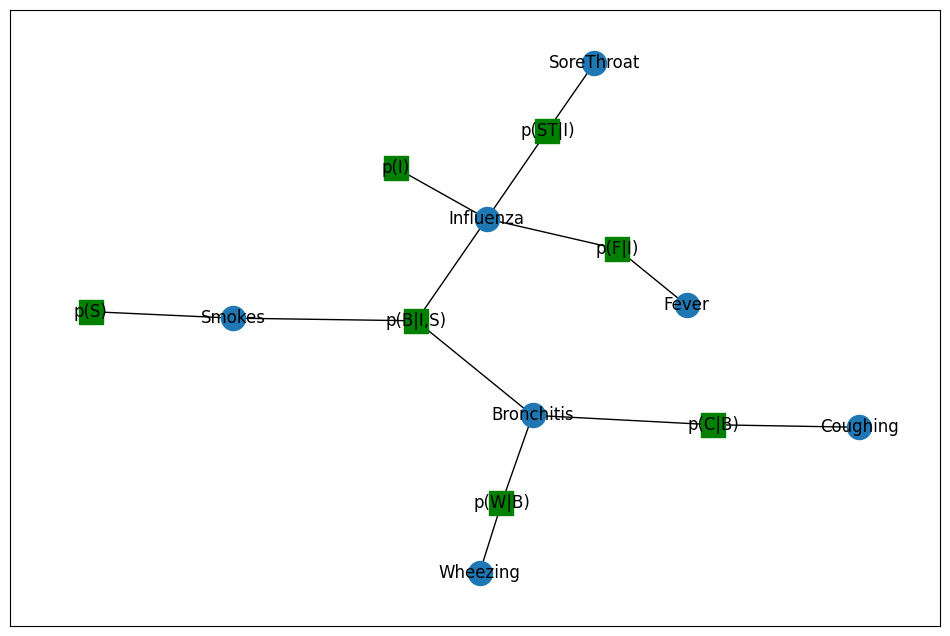

In [24]:
graph = create_medical_graph()
graph.reset()
graph.draw()
graph.max_sum()
print(graph)

In [25]:
graph.reset()
I = graph.get("Influenza")
I.set_observed(0)
graph.max_sum()
print(graph)

[VARIABLE] Sending message from Influenza to []
[VARIABLE] Sending message from Smokes to []
[VARIABLE] Sending message from SoreThroat to ['p(ST|I)']
[VARIABLE] Sending message from Fever to ['p(F|I)']
[VARIABLE] Sending message from Bronchitis to []
[VARIABLE] Sending message from Coughing to ['p(C|B)']
[VARIABLE] Sending message from Wheezing to ['p(W|B)']
[FACTOR] Sending message from p(I) to ['Influenza']
[FACTOR] Sending message from p(S) to ['Smokes']
[FACTOR] Sending message from p(ST|I) to ['Influenza']
[FACTOR] Sending message from p(F|I) to ['Influenza']
[FACTOR] Sending message from p(B|I,S) to []
[FACTOR] Sending message from p(C|B) to ['Bronchitis']
[FACTOR] Sending message from p(W|B) to ['Bronchitis']
[VARIABLE] Sending message from Influenza to ['p(B|I,S)']
[VARIABLE] Sending message from Smokes to ['p(B|I,S)']
[VARIABLE] Sending message from SoreThroat to []
[VARIABLE] Sending message from Fever to []
[VARIABLE] Sending message from Bronchitis to ['p(B|I,S)']
[VARIABL

## Diagnosis (5 points)

Now that we have the max-sum algorithm implemented, we can do some cool things! A friend who smokes calls you and tells you they woke up with a fever, but they don't seem to be coughing nor wheezing and their throat feels fine. Is it likely that they have bronchitis?

In [26]:
graph = create_medical_graph()
graph.reset()
# their throat feels fine. Is it likely that they have bronchitis?
# friend who smokes
S = graph.get("Smokes")
S.set_observed(1)

# woke up with a fever
F = graph.get("Fever")
F.set_observed(1)

# they don't seem to be coughing nor wheezing
C = graph.get("Coughing")
C.set_observed(0)
W = graph.get("Wheezing")
W.set_observed(0)

# their throat feels fine
ST = graph.get("SoreThroat")
ST.set_observed(0)

# Is it likely that they have bronchitis?
graph.max_sum()

print(graph.most_likely())

[VARIABLE] Sending message from Influenza to []
[VARIABLE] Sending message from Smokes to []
[VARIABLE] Sending message from SoreThroat to ['p(ST|I)']
[VARIABLE] Sending message from Fever to ['p(F|I)']
[VARIABLE] Sending message from Bronchitis to []
[VARIABLE] Sending message from Coughing to ['p(C|B)']
[VARIABLE] Sending message from Wheezing to ['p(W|B)']
[FACTOR] Sending message from p(I) to ['Influenza']
[FACTOR] Sending message from p(S) to ['Smokes']
[FACTOR] Sending message from p(ST|I) to ['Influenza']
[FACTOR] Sending message from p(F|I) to ['Influenza']
[FACTOR] Sending message from p(B|I,S) to []
[FACTOR] Sending message from p(C|B) to ['Bronchitis']
[FACTOR] Sending message from p(W|B) to ['Bronchitis']
[VARIABLE] Sending message from Influenza to ['p(B|I,S)']
[VARIABLE] Sending message from Smokes to ['p(B|I,S)']
[VARIABLE] Sending message from SoreThroat to []
[VARIABLE] Sending message from Fever to []
[VARIABLE] Sending message from Bronchitis to ['p(B|I,S)']
[VARIABL

In [27]:
print(graph)

Influenza                 [-5.93500798 -7.60298463]
Smokes                    [       -inf -5.93500798]
SoreThroat                [-5.93500798        -inf]
Fever                     [       -inf -5.93500798]
Bronchitis                [-5.93500798 -7.53986757]
Coughing                  [-5.93500798        -inf]
Wheezing                  [-5.93500798        -inf]
